In [1]:
# 분별 모델
    # SVM, 다층 퍼셉트론, 컨볼류션 신경망, LSTM, 강화학습
    # 표정을보고 감정이나 상태를 알아내는 능력....

# 생성 모델  - deepfake(딥 페이크)
    # 사람의 필기체를 학습... 흉내내는 인공지능
    # HMM : 예전방식
    
    # 2010년~~ 딥러닝 기반의 생성모델
    # GAN : 최신

# 확률적 생성 모델
    # 이미지의 화소 각각에 대해 독립적으로 발생 확률을 추정-> 추정치를 화소값으로 생성하는 단순한모델

In [2]:
# 확률 생성모델을 MNIST에 적용
import numpy as np
from tensorflow.keras.datasets import mnist

In [3]:
(x_train,y_train),(x_target, y_target) =  mnist.load_data()

In [7]:
print(y_train[:10])
np.isin(y_train[:10], [0])

[5 0 4 1 9 2 1 3 1 4]


array([False,  True, False, False, False, False, False, False, False,
       False])

In [14]:
X = x_train[np.isin(y_train,[0])] # 확률 생성모델에.. 필기체가 0일때를 적용  
X.shape

(5923, 28, 28)

In [22]:
# 화소 수준으로 확률 생성 모델  실제 이미지  rgb색상이 적용된 3차원텐서 reshape 28,28,3
# (28,28,256)
#  화소별로 0~255 명함값의 빈도를 구하고 확률로 변환
a = np.zeros((28,28,256))
print(a.shape)
for k in range(X.shape[0]):   # 5923
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            a[i][j][X[k][i][j]] += 1
a = a / X.shape[0]            

(28, 28, 256)


In [23]:
# 확률생성모델을 이용해서 20개의 샘플을 생성
Xnew = np.zeros((20,28,28))
for i in range(20):
    for r in range(28):
        for c in range(28):
            Xnew[i][r][c]  = np.random.choice(range(256),p=a[r][c])  # 확률 분포에 따른 난수를 생성해서 화소 값을결정

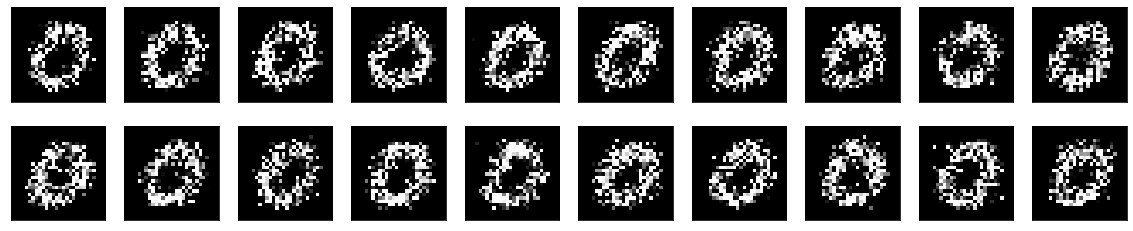

In [24]:
# 화소수준으로 확률적 생성모델이 만든 패턴
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
for i in range(2):
    for j in range(10):
        plt.subplot(2,10,i*10+j+1)
        plt.imshow(Xnew[i*10+j],cmap='gray')
        plt.xticks([]); plt.yticks([])
plt.show()        

In [25]:
# 0형태를유지하지만 품질이 낮다.... 화소간의 상간관계를 고려하지 않았기 때문...

In [26]:
# 오토인코더와 GAN이 대신 해 줌......

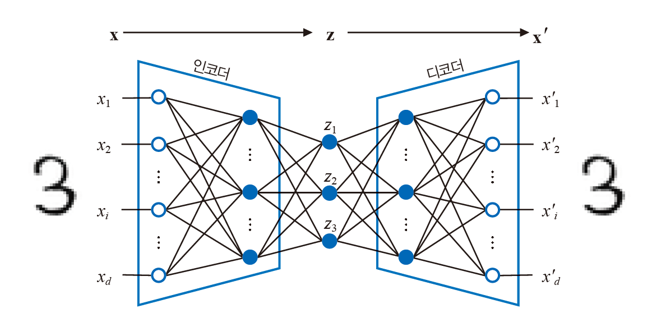

In [28]:
# 오토인코더 : 입력패턴과 출력 패턴이 같은 신경망 
    # 사람이 레이블을 달 필요가 없는 비 지도 학습
    # 영상압축, 잡음제거 -> 일반적인 응용
    # 특징 추출하거나 생성모델--> 딥러닝에서 응용
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/85.PNG", width=500)    
# 은닉층 노드 개수를 축소해서 설계
# 인코더는 차원을 줄이고 디코더는 차원을 회복. z 공간을 잠복 공간 latent space

In [1]:
# mnist를가지고 오토 인코더를 구현 --> 차원을 축소해서 특징을 찾아내는...... 
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten, Reshape,Conv2D, Convolution2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k

In [2]:
# 데이터 로드및 가공
(x_train,y_train),(x_target,y_target) = mnist.load_data()
x_train = x_train / 255.0 ; x_target = x_target / 255.0
x_train.shape

(60000, 28, 28)

In [3]:
x_train = x_train.reshape(-1,28,28,1)
x_target = x_target.reshape(-1,28,28,1)
x_train.shape, x_target.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
# 잠복공간
zdim = 32  # (28*28)인 차수를 32차수로 축소

In [6]:
# 오토인코더 
encorder_input = Input(shape=(28, 28, 1))
x = Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encorder_input)
x = Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x = Flatten()(x)
encorder_output = Dense(zdim)(x)
model_encorder = Model(encorder_input,encorder_output)
model_encorder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 32)                100384

In [7]:
# 오토디코더를 설계
decorder_input = Input(shape=(zdim,))
x=Dense(3136)(decorder_input)
x = Reshape((7, 7, 64))(x)
x = Convolution2DTranspose(64,(3,3),activation='relu', padding='same',strides=(1,1))(x)
x = Convolution2DTranspose(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Convolution2DTranspose(32,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Convolution2DTranspose(1,(3,3),activation='relu', padding='same',strides=(1,1))(x)
decorder_output = x
model_decoder = Model(decorder_input,decorder_output)
model_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 32)       1846

In [8]:
# 오토인코더 = 인코더 + 디코더
model_input = encorder_input
model_output =model_decoder(encorder_output)
model = Model(model_input,model_output)      # 인코더왕 디코더를 결합한 오토인코더에 해당하는 model 객체

In [9]:
# 오토 인코더 학습  Adam  손실함수는 mse   compile
# fit epoch=5,batch_size=128,
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train, epochs=5,batch_size=128,shuffle=True, validation_data=(x_target,x_target))

Epoch 1/5
469/469 [==============================] - 81s 171ms/step - loss: 0.0230 - val_loss: 0.0070
Epoch 2/5
469/469 [==============================] - 76s 162ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 3/5
469/469 [==============================] - 76s 162ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 4/5
469/469 [==============================] - 76s 163ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 5/5
469/469 [==============================] - 76s 162ms/step - loss: 0.0038 - val_loss: 0.0036


In [13]:
# 복원
decoded_img =  model.predict(x_target)  # 테스트집합에 대해 예측을 수행-> 이미지를 인코딩->디코딩

In [12]:
import matplotlib.pyplot as plt

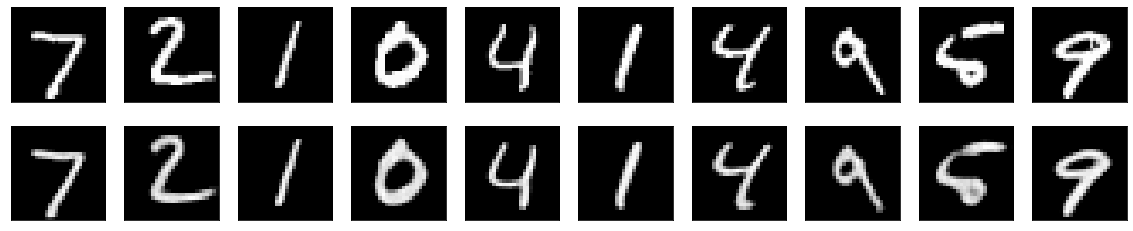

In [14]:
plt.figure(figsize=(20,4))
for i in range(10):
    # 테스트 원본이미지
    plt.subplot(2,10,i+1)
    plt.imshow(x_target[i].reshape(28,28),cmap="gray")
    plt.xticks([]); plt.yticks([])
    
    # 오토인코더가 예측한 이미지
    plt.subplot(2,10,10+i+1)
    plt.imshow(decoded_img[i].reshape(28,28),cmap="gray")
    plt.xticks([]); plt.yticks([])
plt.show()    

In [ ]:
# Functional API를 사용
# 신경망의 중간층에 접근할 필요가 있어서 Functional API
# C - C - FC
# Sequencial 방식
from tensorflow.keras.models imort Sequential
tempmodel = Sequential()
tempmodel.add(Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)))
tempmodel.add(Conv2D(64,(3,3),activation='relu'))
tempmodel.add(Flatten())
tempmodel.add(Dense(10,activation='softmax'))

#----------------------
# Functional API
input = Input(shape=(28,28,1))
x1 = Conv2D(32,(3,3), activation='relu')(input)
x2 = Conv2D(64,(3,3),activation='relu')(x1)
x3 = Flatten()(x2)
output = Dense(10,activation='softmax')(x3)
temp2model = Model(input,output)

In [15]:
# 잠복공간 : 원래팬턴하고 거의 비슷하게 복원, 원래 패턴을 충실하게 표현하는 고수준 특징
# 784차원을 32로 축소했는데 원본과 거의 비슷하다는 애기는
# 인코더만 보면  훌륭한 차원 축소기.... 이미지계의 PCA다.. 즉 특징 추출기로  사용가능
# 인코더 + 다층퍼셉트론 또는 SVM을 붙이면 훌륭한 숫자 인식기(딥러닝)
# 현재의 딥러닝은 오토인코더를 사용안해도 높은 성능을 달성.. 애를 특징 추출기로 사용하는 사례는 줄고있음
# 하지만... 생성 모델로는 많이 사용 --> 새로운 샘플을 생성

In [16]:
# 오토인코더를 생성모델로 활용여부...

In [17]:
# 테스트 1 : 첫번째 샘플의 잠복공간에 노이즈를 임의로 섞어서 샘플을 생성
import numpy as np
x0 = x_target[0]
z = model_encorder.predict(x0.reshape(1,28,28,1)) # 샘플에 대해서 인코더로 잠복공간의 점을 예측
print(np.round(z,3))

[[ 0.647  0.14  -0.947  1.201 -0.018  0.43   0.026  0.985 -0.037 -0.872
   0.314  0.678 -1.561 -0.131 -0.368  0.326 -0.153 -1.491  0.204 -0.267
  -0.344 -0.207 -0.469  0.465  0.671 -0.515  1.409 -0.65   1.33   1.26
   0.487 -0.61 ]]


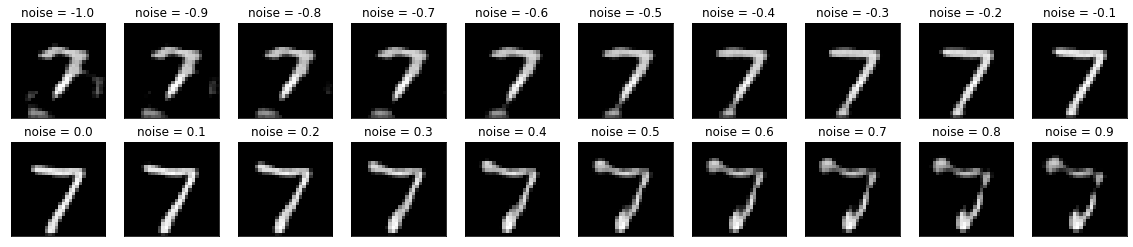

In [29]:
zz = np.zeros((20,zdim))
for i in range(20):           # 잠복공간에 노이즈를 섞음
    zz[i] = z[0]+(i-10)/10.0
# print(zz)  
generated_img = model_decoder.predict(zz)  # 노이즈가 있는 점에 대해서 디코더로 샘플을 생성

plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.title('noise = '+str((i-10)/10.0))
plt.show()    


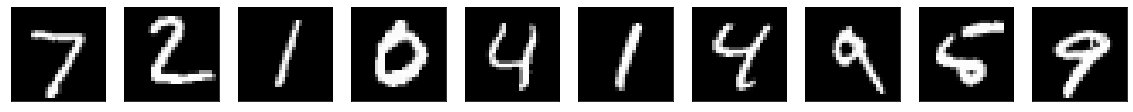

In [30]:
# 같은 숫자의 두 개의 샘플의 값 사이의 차이를 이용하여 새로운 샘플을 생성
plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_target[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()    

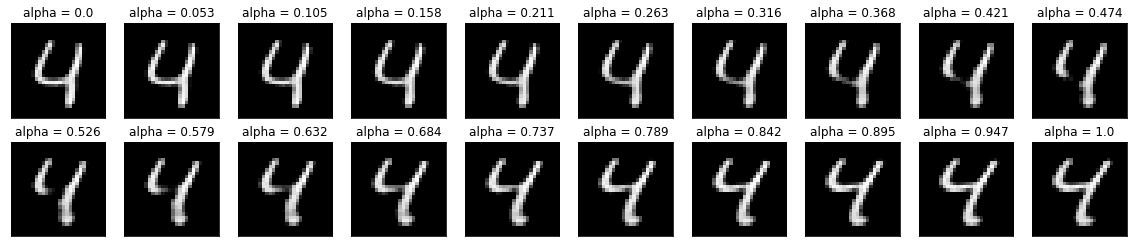

In [33]:
# x_target[4]  x_target[6]
x_46 =  np.array((x_target[4],x_target[6]))
z = model_encorder.predict(x_46)
zz = np.zeros((20,zdim))   # 잠복공간의 점을 예측하는데.. 인코도를 이용
for i in range(20):
    alpha = i/(20.0-1.0)  # 두 잠복공간의 점을 연결하는 선분상에서 20개의 점을 생성
    zz[i] = (1.0-alpha)*z[0]+alpha*z[1]
generated_img = model_decoder.predict(zz)    

plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    plt.title('alpha = '+str( round(i/(20.0-1.0),3) ))
plt.show() 
# 두개의 이미지사이를 보간

In [34]:
# 오토인코더는 생성모델로 가능성존재
# 중간중간에 품질이 떨어지는 경우가 다수 존재

In [36]:
# 2차원 공간에서 테스트 집합을 시각화하여 오토인코더의 성능을 테스트
zdim = 2
# 오토인코더 
encorder_input = Input(shape=(28, 28, 1))
x = Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encorder_input)
x = Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x = Flatten()(x)
encorder_output = Dense(zdim)(x)
model_encorder = Model(encorder_input,encorder_output)
# 오토디코더를 설계
decorder_input = Input(shape=(zdim,))
x=Dense(3136)(decorder_input)
x = Reshape((7, 7, 64))(x)
x = Convolution2DTranspose(64,(3,3),activation='relu', padding='same',strides=(1,1))(x)
x = Convolution2DTranspose(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Convolution2DTranspose(32,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Convolution2DTranspose(1,(3,3),activation='relu', padding='same',strides=(1,1))(x)
decorder_output = x
model_decoder = Model(decorder_input,decorder_output)
# 오토인코더 = 인코더 + 디코더
model_input = encorder_input
model_output =model_decoder(encorder_output)
model = Model(model_input,model_output)      # 인코더왕 디코더를 결합한 오토인코더에 해당하는 model 객체
#학습
model.compile(optimizer='Adam',loss='mse')
model.fit(x_train,x_train, epochs=5,batch_size=128,shuffle=True, validation_data=(x_target,x_target))

Epoch 1/5
469/469 [==============================] - 81s 172ms/step - loss: 0.0543 - val_loss: 0.0472
Epoch 2/5
469/469 [==============================] - 76s 162ms/step - loss: 0.0447 - val_loss: 0.0428
Epoch 3/5
469/469 [==============================] - 76s 161ms/step - loss: 0.0423 - val_loss: 0.0418
Epoch 4/5
469/469 [==============================] - 76s 162ms/step - loss: 0.0411 - val_loss: 0.0410
Epoch 5/5
469/469 [==============================] - 75s 161ms/step - loss: 0.0404 - val_loss: 0.0403


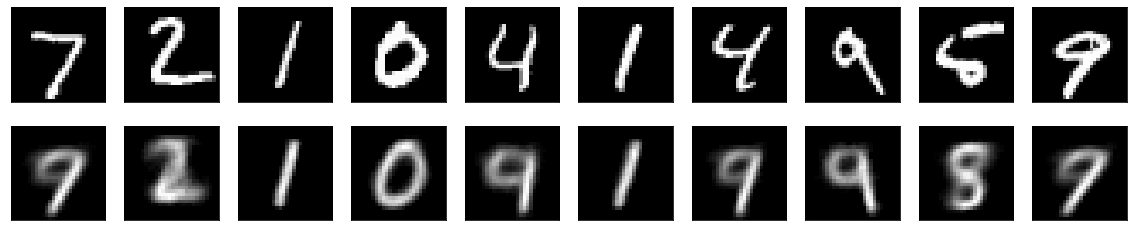

In [38]:
# 품질테스트 2차원으로 잠복공간을 설정했을때
decoded_img = model.predict(x_target)

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_target[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    
    plt.subplot(2,10,10+i+1)
    plt.imshow(decoded_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    
plt.show() 


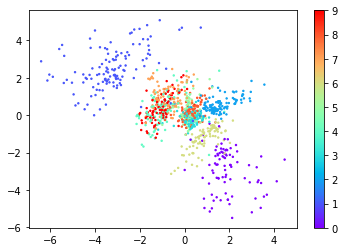

In [48]:
x_1000 = x_target[:1000]
z =  model_encorder.predict(x_1000)
sc = plt.scatter(z[:,0], z[:,1],s=2,c=y_target[:1000], cmap='rainbow')
plt.colorbar(sc)

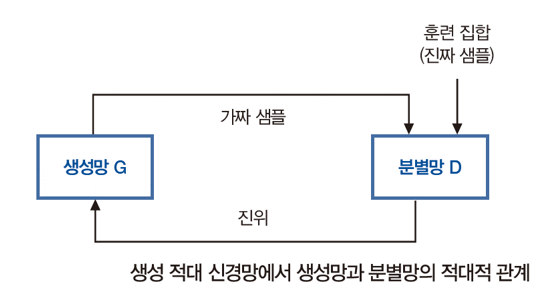

In [49]:
# 생성적대 신경망 
# GAN(generative adversarial network) : 2개의 신경망이 학습을 하는데. 서로 적대적인 관계에서 학습
# 개량--> ProGAN이 가장 뛰어남 - 이미지 디텍딩... 딥페이크를 구분하는 용도
# GAN의 학습 알고리즘
# G는 D를 속일수 있을 정도로 품질이 높은 가짜 샘플을 생성
# D는 G가 만든 가짜를 높은 정확률로 맞춤
# 위조지폐범과 경찰 --> 위조지폐범이 승리해야 만 함
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/86.PNG", width=500)

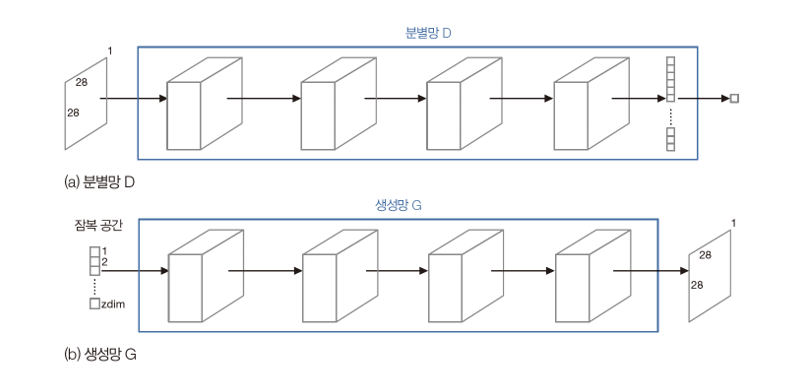

In [50]:
# MNIST로 적용
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/87.PNG", width=500)
# 분별망 D : 입력은 28*28영상, 출력노드1( 1 진짜 0가짜, 활성함수 : sigmoid)
# 생성망 G : 입력은 z-dim차원의 잠복공간의 한점의 좌표, 출력은 28*28영상 - 오토인코더와 비슷

In [51]:
# 학습
# 분별망은 이진분류 비교적 쉬움
# 생성망 학습 : 가짜샘플에 레이블 1을 붙여서 학습 즉 분별망을 속이는 행위
# 이때 가중치는 고정

In [55]:
# mnist를 이용한 적대 신경망
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Activation,Dense, Flatten,Reshape 
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, Dropout,BatchNormalization,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k
from tensorflow.keras.losses import mse
import matplotlib.pylab as plt

In [56]:
# scaling.. -1 ~ 1
(x_train,y_train),(x_target,y_target) =  mnist.load_data()
x_train = (x_train/255.0)*2.0-1.0
x_target = (x_target/255.0)*2.0-1.0

x_train = x_train.reshape(-1,28,28,1)
x_target = x_target.reshape(-1,28,28,1)

# 하이퍼 파라메터
batch_size = 64
epochs = 5000
dropout_rate = 0.9
zdim = 100

In [ ]:
# 분별망 D 설계
discriminator_input = Input(shape=(28,28,1))
x = Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x = Dropout(dropout_rate)(x)

x = Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
discriminator_output = Dense(1,activation='sigmoid')
discriminator = Model(discriminator_input,discriminator_output)